In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from read_csv_data import *
from my_filter import *
from my_load_data import * 
from my_predict import *
from my_util import *


In [2]:
path_root = './data/'
sns.set()
# load data
Y_raw, Y_drug_id, Y_drug_name, tissue_id_list, tissue_name_list, dataset_id, X_gene_symbol_list, X_oncogene_idx = my_load_data(path_root)
X_gene_ENSG_list = my_load_ENSG(path_root)

In [14]:
# load X_raw (gene expression of cell lines)

X_raw = my_load_data_X_tpm(path_root)

print( 'X_raw.shape = ', X_raw.shape )

X_raw.shape =  (1047, 37279)


In [15]:
#####################################
select_dataset = 0
dataset_train_ids = [0]
dataset_test_ids = [0]    # 1 = CCLE, 2 = GDSC; 0 = mixing CCLE and GDSC

########################################
# Selected the tissue to analyze
tissue_selected_id_list_list = [[14]]  # 5 = Breast
# tissue_selected_id_list_list = [[14]]  # 14 = Colorectal 
# tissue_selected_id_list_list = [[16]]  # 16 = Lung

# drug list (GDSC id)
# drug_id_list_list =  [1003, 1004, 1005, 1006, 1007, 1010, 1011, 1012, 1013, 1017, 
# 1021, 1022, 1025, 1030, 1032, 1034, 1036, 1038, 1042, 1046, 
# 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1057, 1058, 
# 1059, 1060, 1068, 1073, 1079, 1080, 1083, 1084, 1085, 1086, 
# 1088, 1089, 1091, 1093, 1096, 1129, 1131, 1168, 1177, 1179, 
# 1180, 1190, 1191, 1192, 1194, 1199, 1200, 1237, 1239, 1248, 
# 1249, 1250, 1259, 1268, 1372, 1373, 1375, 1401, 1428, 1441, 
# 1449, 1463, 1507, 1510, 1511, 1512, 1529, 1549, 1553, 1557, 
# 1558, 1559, 1560, 1561, 1563, 1564, 1576, 1578, 1593, 1594, 
# 1598, 1613, 1614, 1615, 1617, 1618, 1620, 1621, 1622, 1624, 
# 1625, 1626, 1627, 1629, 1630, 1631, 1632, 1634, 1635, 1706, 
# 1708, 1709, 1712, 1713, 1714, 1716, 1718, 1720, 1730, 1732, 
# 1733, 1734, 1736, 1738, 1739, 1786, 1799, 1802, 1804, 1806, 
# 1807, 1808, 1809, 1810, 1811, 1813, 1814, 1816, 1818, 1819, 
# 1825, 1827, 1830, 1835, 1838, 1849, 1852, 1853, 1854, 1855, 
# 1862, 1866, 1873, 1908, 1909, 1910, 1911, 1912, 1913, 1915, 
# 1916, 1917, 1918, 1919, 1922, 1924, 1925, 1926, 1927, 1928, 
# 1930, 1931, 1932, 1933, 1936, 1939, 1940, 1941, 1996, 1997, 
# 1998, 2040, 2043, 2044, 2045, 2046, 2047, 2048, 2096, 2106, 
# 2107, 2109, 2110, 2111, 2169, 2170, 2171, 2172]  # all 198 drugs in GDSC
# drug_id_list_list = [1005, 1073, 1080, 1512]  # 1005=Cisplatin, 1073=5FU, 1080=Paclitaxel, 1512=Cyclophosphamide
drug_id_list_list = [1073]  # 1004=Vinblastine, 1007=Docetaxel, 1088=Irinotecan, 1089=Oxaliplatin



# parameters for training
C_cv_fold = 5     # N-fold cross valiadation
C_drug_sens_threshold = -1   # threshold of z-score to distinguish drug-sensitive and drug-resistant

flag_oncogene = False      # if True, select genes in 723 oncogenes 
flag_tpm_normalize = True  # if True, TPM normalize the gene expression before prediction

In [47]:
for iii_ in range(len(drug_id_list_list)):
    
    # drug information
    if type(drug_id_list_list[iii_]) is list:
        drug_id_list = drug_id_list_list[iii_]
    else:
        drug_id_list = [drug_id_list_list[iii_]]
    Y_drug_idx = [ 0 for i in range(len(drug_id_list))]
    for i in range(len(drug_id_list)):
        drug_id = drug_id_list[i]
        Y_drug_idx[i] = np.argwhere(Y_drug_id==drug_id)[0][0]
        print('drug name:',Y_drug_name[Y_drug_idx[i]],'; drug id:',drug_id)

    ###########################################
    X_idx_all_list = []        # screened gene idx
    X_idx_score_all_list = []  # score of these screened genes

    for select_dataset in dataset_train_ids:  # Specify the database
        for tissue_selected_id_list in tissue_selected_id_list_list: # Specify the tissue

            X_idx_all = np.array([])        # screened gene idx
            X_idx_score_all = np.array([])  # score of these screened genes

            for i in range(len(Y_drug_idx)):  # Specify the drug
                drug_idx = Y_drug_idx[i]
                drug_id = Y_drug_id[drug_idx]
                drug_name = Y_drug_name[drug_idx]

                print()
                print('drug_id =', drug_id, ' drug_name =', drug_name)

                X = X_raw.copy()
                X = np.log(1+X)     
                X_idx = np.array([i for i in range(X.shape[1])])
                Y = Y_raw[drug_idx, :]
                    
                # specified database, and tissue
                X_cell_idx = my_data_selection_2(dataset_id, select_dataset, tissue_id_list, tissue_selected_id_list)
                # remove cell lines without drug info
                X_cell_idx = X_cell_idx[~np.isnan(Y[X_cell_idx])]
                
                # Cell lines with specified database, and tissue
                X = X[X_cell_idx, :]
                Y = Y[X_cell_idx]


                if Y.shape[0]<5:
                    print('[Warning] not enough data points (%d)'%(Y.shape[0]))
                    continue

                # re-normalize Y (z-score) to ensure mean=0 and std=1
                Y = my_normalize(Y)
                Y[Y<-2] = -2
                Y[Y>2] = 2
                
                print('len(X):',len(X))
                print('len(Y):',len(Y))

drug name: 5-Fluorouracil ; drug id: 1073

drug_id = 1073  drug_name = 5-Fluorouracil
selecting tissue;   X_cell_idx: (57,)
len(X): 48
len(Y): 48


In [48]:
#filters based on Expression
###### Expression level filter: mean gene expression cannot be too low
Filter_idx = np.argwhere(np.mean(X, axis=0)>1).T[0]
X_filter1 = X[:, Filter_idx]
X_idx = X_idx[Filter_idx]
print('after expression level filter, X_filter1:', X_filter1.shape)

gene_select = []
for i in X_idx:
    gene_select.append(X_gene_symbol_list[i])
print("after expression level filter, gene select:", len(gene_select))

after expression level filter, X_filter1: (48, 11431)
after expression level filter, gene select: 11431


In [49]:
#transform the format of expression to pandas
from pandas import DataFrame

X_expression = np.concatenate((np.array(gene_select).reshape(1,-1), X_filter1))
X_expression_pd = DataFrame(X_filter1,columns = gene_select)
print(X_expression_pd)

      A4GALT      AAAS      AACS     AADAT     AAED1     AAGAB      AAK1  \
0   0.000000  3.162631  2.842943  2.370218  1.442968  4.080894  1.442968   
1   2.760150  3.637731  2.128363  4.034387  2.970556  4.213755  1.547680   
2   2.106628  3.268491  2.947130  1.528280  2.106628  4.726657  2.106628   
3   1.491827  3.568183  2.693332  3.075987  1.491827  4.427060  1.491827   
4   0.000000  3.396357  2.835013  3.675630  2.003134  3.956958  1.436542   
5   1.305331  3.721677  2.204611  2.670317  1.305331  4.298653  1.305331   
6   2.651643  3.524691  1.457295  3.524691  1.457295  4.340808  1.457295   
7   0.000000  3.871649  2.043472  1.472169  2.043472  3.799142  0.000000   
8   0.000000  3.610017  2.467252  2.103322  2.103322  4.814513  1.525332   
9   0.000000  4.230794  2.412853  2.677891  2.412853  3.729615  1.479008   
10  1.855632  3.331443  2.207571  1.855632  1.307757  3.724923  1.307757   
11  0.000000  3.519885  2.766334  0.000000  1.381294  4.241918  0.000000   
12  2.235227

In [19]:
# get the drug sensity
drug_sensity = DataFrame(Y,columns=['Drug Sensity'])

In [20]:
#5 fold split

from sklearn.model_selection import KFold

train_index_list = []
test_index_list=[]
kf = KFold(n_splits=5, random_state=62,shuffle=True)
for train_index, test_index in kf.split(X_expression_pd.values, drug_sensity.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_index_list.append(train_index)
    test_index_list.append(test_index)



TRAIN: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 17 18 19 20 21 22 24 26 28 29 30
 32 33 34 35 36 37 38 40 41 42 43 44 45 46] TEST: [ 2  4 15 16 23 25 27 31 39 47]
TRAIN: [ 0  1  2  3  4  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25 27 29 30
 31 33 34 35 36 37 38 39 40 42 44 45 46 47] TEST: [ 5  6  7 20 22 26 28 32 41 43]
TRAIN: [ 0  1  2  4  5  6  7  9 10 11 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 36 37 39 40 41 43 44 45 47] TEST: [ 3  8 12 13 14 34 35 38 42 46]
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 20 22 23 24 25 26 27 28
 30 31 32 34 35 36 37 38 39 41 42 43 45 46 47] TEST: [ 0  1 10 19 21 29 33 40 44]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 12 13 14 15 16 19 20 21 22 23 25 26 27 28
 29 31 32 33 34 35 38 39 40 41 42 43 44 46 47] TEST: [ 9 11 17 18 24 30 36 37 45]


In [21]:
#####get each fold 
cv1_x_train = X_expression_pd.iloc[train_index_list[0]]
cv1_x_test = X_expression_pd.iloc[test_index_list[0]]
cv1_y_train = drug_sensity.iloc[train_index_list[0]]

cv2_x_train = X_expression_pd.iloc[train_index_list[1]]
cv2_x_test = X_expression_pd.iloc[test_index_list[1]]
cv2_y_train = drug_sensity.iloc[train_index_list[1]]

cv3_x_train = X_expression_pd.iloc[train_index_list[2]]
cv3_x_test = X_expression_pd.iloc[test_index_list[2]]
cv3_y_train = drug_sensity.iloc[train_index_list[2]]

cv4_x_train = X_expression_pd.iloc[train_index_list[3]]
cv4_x_test = X_expression_pd.iloc[test_index_list[3]]
cv4_y_train = drug_sensity.iloc[train_index_list[3]]

cv5_x_train = X_expression_pd.iloc[train_index_list[4]]
cv5_x_test = X_expression_pd.iloc[test_index_list[4]]
cv5_y_train = drug_sensity.iloc[train_index_list[4]]

In [22]:
cv1_y_test = drug_sensity.iloc[test_index_list[0]]
cv2_y_test = drug_sensity.iloc[test_index_list[1]]
cv3_y_test = drug_sensity.iloc[test_index_list[2]]
cv4_y_test = drug_sensity.iloc[test_index_list[3]]
cv5_y_test = drug_sensity.iloc[test_index_list[4]]

In [142]:
#### transform the data format to csv, and then execute the RF(random forest) or DL(deep learning) algorithm in R(batch_correct.R&tune_drug.R)
cv1_x_train.to_csv('cv1_x_train.csv',sep='\t')
cv1_x_test.to_csv('cv1_x_test.csv',sep='\t')

cv2_x_train.to_csv('cv2_x_train.csv',sep='\t')
cv2_x_test.to_csv('cv2_x_test.csv',sep='\t')

cv3_x_train.to_csv('cv3_x_train.csv',sep='\t')
cv3_x_test.to_csv('cv3_x_test.csv',sep='\t')

cv4_x_train.to_csv('cv4_x_train.csv',sep='\t')
cv4_x_test.to_csv('cv4_x_test.csv',sep='\t')

cv5_x_train.to_csv('cv5_x_train.csv',sep='\t')
cv5_x_test.to_csv('cv5_x_test.csv',sep='\t')

In [23]:
#####get the results after batch correct in R(batch_correct.R)
import pandas as pd
cv1_correct = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/cv1_cells_correct.csv',sep='\t')
cv2_correct = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/cv2_cells_correct.csv',sep='\t')
cv3_correct = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/cv3_cells_correct.csv',sep='\t')
cv4_correct = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/cv4_cells_correct.csv',sep='\t')
cv5_correct = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/cv5_cells_correct.csv',sep='\t')

In [168]:
#####insert the drug sensity in the first column
cv1_correct.insert(0, '5FU', cv1_y_train['Drug Sensity'])
cv2_correct.insert(0, '5FU', cv2_y_train['Drug Sensity'])
cv3_correct.insert(0, '5FU', cv3_y_train['Drug Sensity'])
cv4_correct.insert(0, '5FU', cv4_y_train['Drug Sensity'])
cv5_correct.insert(0, '5FU', cv5_y_train['Drug Sensity'])


cv1_correct.to_csv('cv5_train_correct.csv',sep='\t')
cv2_correct.to_csv('cv5_train_correct.csv',sep='\t')
cv3_correct.to_csv('cv5_train_correct.csv',sep='\t')
cv4_correct.to_csv('cv5_train_correct.csv',sep='\t')
cv5_correct.to_csv('cv5_train_correct.csv',sep='\t')


0.9416666666666667


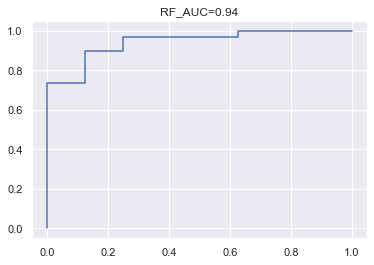

In [82]:
#### training loss in the 3rd fold in Random Forest
from sklearn import metrics

rf_cross_val = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cross_val__clinicalPrediction.csv')['ic50'].values
auc_rf_cross = metrics.roc_auc_score(cv3_y_train.values>-1, rf_cross_val)
print(auc_rf_cross)

fpr_rf_train, tpr_rf_train, thresholds_rf_train = metrics.roc_curve(cv3_y_train.values > -1, rf_cross_val)
plt.plot(fpr_rf_train,tpr_rf_train)
plt.title('RF_AUC=%.2f'%(auc_rf_cross))
plt.show()

0.975


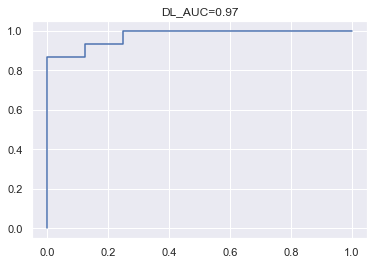

In [81]:
### training loss in the 3rd fold in Deep learning
from sklearn import metrics

dl_cross_val_cv3 = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cross_val_cv3_clinicalPrediction.csv')['ic50'].values

auc_cv_cross = metrics.roc_auc_score(cv3_y_train.values>-1, dl_cross_val_cv3)
print(auc_cv_cross)


fpr_dl_train, tpr_dl_train, thresholds_dl_train = metrics.roc_curve(cv3_y_train.values > -1, dl_cross_val_cv3)
plt.plot(fpr_dl_train,tpr_dl_train)
plt.title('DL_AUC=%.2f'%(auc_cv_cross))
plt.show()

In [64]:
### get the prediction of each fold in Random Forest
cv1_pre_rf = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cv1_15_clinicalPrediction.csv')
cv2_pre_rf = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cv2_15_clinicalPrediction.csv')
cv3_pre_rf = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cv3_15_clinicalPrediction.csv')
cv4_pre_rf = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cv4_15_clinicalPrediction.csv')
cv5_pre_rf = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/rf_cv5_15_clinicalPrediction.csv')

In [65]:
### get the prediction of each fold in Deep learning
cv1_pre_dl = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cv1_15_clinicalPrediction.csv')
cv2_pre_dl = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cv2_15_clinicalPrediction.csv')
cv3_pre_dl = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cv3_15_clinicalPrediction.csv')
cv4_pre_dl = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cv4_15_clinicalPrediction.csv')
cv5_pre_dl = pd.read_csv('F:/deep-drug-response-master/deep-drug-response-master/dl_cv5_15_clinicalPrediction.csv')

In [77]:
####merge the prediction in random forest
rf_y_pre = pd.concat([cv1_pre_rf,cv2_pre_rf,cv3_pre_rf,cv4_pre_rf,cv5_pre_rf],axis=0).set_index('patient_id').sort_index().values.reshape(1,-1)[0]

In [67]:
####merge the prediction in deep learning
dl_y_pre = pd.concat([cv1_pre_dl,cv2_pre_dl,cv3_pre_dl,cv4_pre_dl,cv5_pre_dl],axis=0).set_index('patient_id').sort_index().values.reshape(1,-1)[0]

0.5421875


Text(0.5, 1.0, 'RF_AUC=0.54')

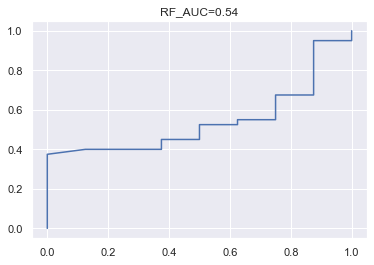

In [85]:
###cross validation results of Random forest
auc_rf = metrics.roc_auc_score(Y>-1, rf_y_pre)
print(auc_rf)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y > -1, rf_y_pre)
plt.plot(fpr_rf,tpr_rf)
plt.title('RF_AUC=%.2f'%(auc_rf))


0.6375


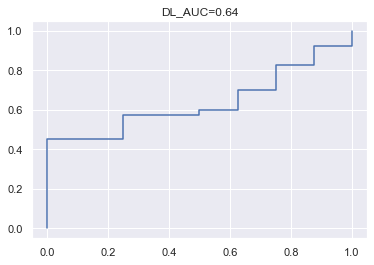

In [84]:
#### cross-validation results of deep learning
auc_dl = metrics.roc_auc_score(Y>-1, dl_y_pre)
print(auc_dl)
fpr_dl, tpr_dl, thresholds_dl = metrics.roc_curve(Y > -1, dl_y_pre)
plt.plot(fpr_dl,tpr_dl)
plt.title('DL_AUC=%.2f'%(auc_dl))
plt.show()